In [1]:
import matplotlib.pyplot as plt 
import os
import torch
import torchaudio as ta 
from pathlib import Path
from torch.utils.data import DataLoader, Subset
import utils 
import warnings

#### Filename structure:

6229: Soundtrap#6229

22: 2022

08: August

21: Hour of day(?)

x: Iterator(?)

In [36]:
# Ignore userwarnings due to TorchAudio deprecating in next major release (2.9.0, late 2025).
warnings.filterwarnings("ignore", category=UserWarning)

# Path setup.
root_folder = Path().resolve().parents[0]
data_path = root_folder / "data_dryad" / "Aug_6229"
graph_path = root_folder / "bsc_project" / "graphs"

# sample_name = "6229.220802160000.wav"
sample_name = data_path / "6229.220802160000.wav"
# sample_name = data_path / "6229.220802162000.wav"
sample_wav = os.path.join(data_path, sample_name)

In [3]:
metadata = ta.info(sample_wav)
print(metadata)

AudioMetaData(sample_rate=64000, num_frames=17279744, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [4]:
waveform, sample_rate = ta.load(sample_wav)

#### Audio data:
- 64 kHz: higher resolution than common sound (16 kHz).
- 1 channel with 17 million frames.
- time = num_frames / sample_rate $\approx$ 4.5 mins.

#### Basic waveform plot
Runs very slowly because of the high resolution.

Based on https://docs.pytorch.org/audio/stable/tutorials/audio_io_tutorial.html

In [5]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_ax = torch.arange(0, num_frames) / sample_rate

    fig, ax = plt.subplots(num_channels, 1)
    ax.plot(time_ax, waveform[0], linewidth=1, color="royalblue", alpha=0.8)
    ax.grid(True)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    fig.suptitle("Waveform")

In [6]:
# plot_waveform(waveform, sample_rate)

#### Faster waveform plot
Only designed for for mono-channel audio.

In [7]:
def plot_waveform_fast(waveform, sample_rate, max_pts:int=30_000, title:str="Waveform", ax=None):
    n_channels, n_frames = waveform.shape
    # Truncation steps only for visualizing waveforms.
    stride = max(1, n_frames // max_pts) 
    wf_visual = waveform[:, ::stride]
    # Time in seconds: time = frames / sample_rate and strides are frames divided by steps.  
    t = torch.arange(wf_visual.shape[1], dtype=torch.float32) * (stride / sample_rate) 

    wf_visual = wf_visual.cpu().numpy()
    t = t.cpu().numpy()

    if ax is None: 
        fig, ax = plt.subplots(figsize=(10, 3))
    else: 
        fig = None

    ax.plot(t, wf_visual[0], linewidth=1, color="royalblue", alpha=0.8)
    ax.grid(True, linewidth=0.5, alpha=0.5)
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    
    return fig, ax 

(<Figure size 1000x300 with 1 Axes>,
 <Axes: title={'center': 'Waveform'}, xlabel='Time (seconds)', ylabel='Amplitude'>)

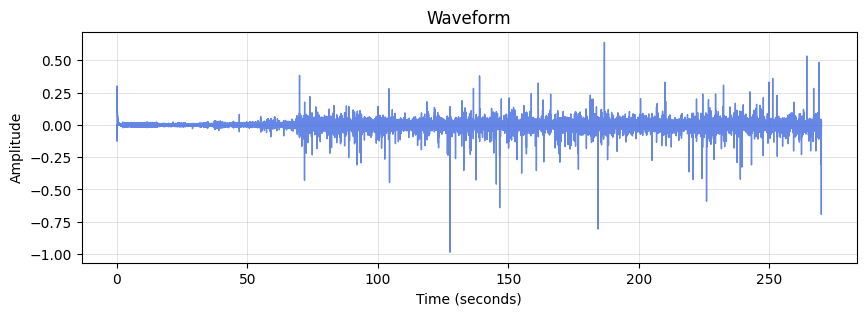

In [8]:
plot_waveform_fast(waveform, sample_rate)

#### Data loader
Based on https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html.

In [9]:
start_idx = 0 # Create a data subset to skip to later recordings.
batch_size = 2
dataset = utils.AudioDataset(data_path, target_sr=sample_rate, max_secs=None)
subset = Subset(dataset, range(start_idx, len(dataset)))
loader = DataLoader(subset, batch_size=batch_size, shuffle=False, collate_fn=utils.max_len_collate) # Only shuffle data when training.

Manually checked data subset up to index $=9 \cdot 40$.

In [10]:
# max_points = 30_000
# rows, cols = 3, 3
# fig, axes = plt.subplots(rows, cols, figsize=(12, 9))
# axes = axes.flatten()
# n_plots = rows * cols 

# file_list = []
# i = 0
# for waves, srs, paths, lengths in loader:
#     for w, sr, path, l in zip(waves, srs, paths, lengths):
#         if i >= n_plots:
#             break
#         p = Path(path).name
#         L = int(l) if hasattr(l, "item") else int(l)
#         waveclip = w[:, :L].detach().cpu()
#         plot_waveform_fast(waveclip, sr, max_points, title=p, ax=axes[i])
#         file_list.append(p)
#         i += 1
#     if i >= n_plots:
#         break 

# plt.tight_layout()
# plt.show()

### Notes
- Every .wav file seems to begin with 1 second of noise.

#### Notable files
'6229.220802160000.wav', '6229.220802162000.wav', '6229.220802164000.wav', '6229.220804080000.wav', '6229.220805090000.wav', '6229.220805094000.wav', '6229.220805100000.wav', '6229.220805102000.wav', '6229.220805104000.wav', '6229.220805110000.wav', '6229.220805112000.wav', '6229.220805114000.wav', '6229.220806052000.wav', '6229.220806184000.wav'

#### Find interesting waveforms with high amplitudes
- Skip the first corrupted seconds. 
- Find waveforms with peaks and fractions of their wave length above amplitude peak $0.3$ and length fraction $5e-6$ (a fraction of a million).

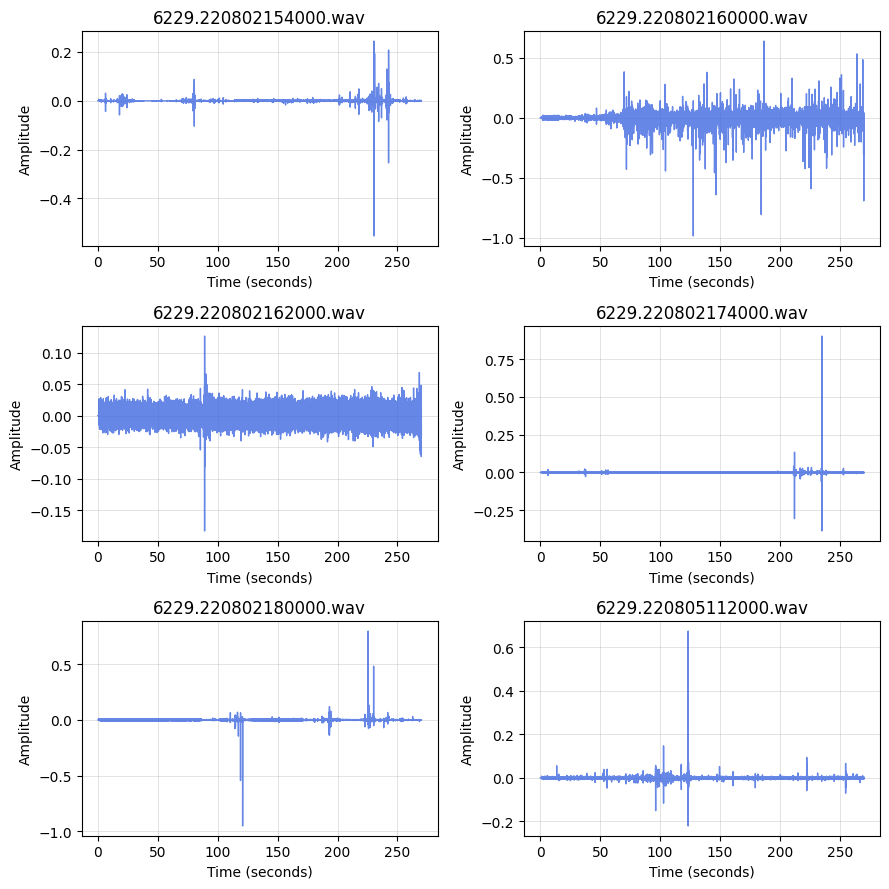

In [39]:
skip_secs = 1
ampl_threshold = 0.3
ampl_frac = 5e-6
wavelist = []

max_points = 30_000
rows, cols = 3, 2
num_plots = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
axes = axes.flatten()

n_plts = 0
for waves, srs, paths, lengths in loader:
    for w, sr, path, l in zip(waves, srs, paths, lengths):
        if n_plts >= num_plots:
            break 

        n_chans, n_frames = w.shape 
        s_idx = int(sr * skip_secs)
        waveclip = w[:, :l]
        waveclip[:, :s_idx] = 0 # Mute the first corrupted seconds of every recording.
        wavepeak = float(waveclip.abs().max().item())
        wavefrac = float((waveclip.abs() >= ampl_threshold).float().mean().item())
        if wavefrac >= ampl_frac and wavepeak >= ampl_threshold:
            p = Path(path).name
            wavelist.append((path))
            plot_waveform_fast(waveclip, sr, max_points, title=p, ax=axes[n_plts])
            n_plts += 1 

    if n_plts >= num_plots:
        break 
plt.savefig(fname=graph_path / "waveforms_graph.png", dpi=300)
plt.tight_layout()
plt.show()

#### Spectrograms

In [ ]:
def plot_specgram(waveform, sample_rate, title:str="Spectrogram", ax=None):
    
    n_channels, n_frames = waveform.shape
    wf = waveform.numpy()

    if ax is None: 
        fig, ax = plt.subplots(n_channels, 1, figsize=(7,6))
    else: 
        fig = None

    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Frequency")
    ax.specgram(wf[0], Fs=sample_rate, scale_by_freq=True)
    ax.set_title(title)

    return fig, ax

(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Spectrogram: 6229.220802160000.wav'}, xlabel='Time (seconds)', ylabel='Frequency'>)

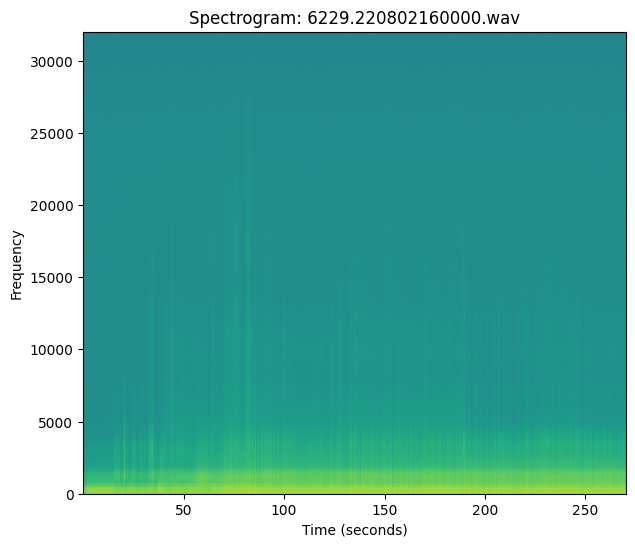

In [67]:
# sample_name = '6229.220806184000.wav'
# sample_name = "6229.220802162000.wav"
sample_name = "6229.220802160000.wav"
sample_wav = os.path.join(data_path, sample_name)
waveform, sample_rate = ta.load(sample_wav)
plot_specgram(waveform, sample_rate, title=r"Spectrogram: " + sample_name)

#### Spectrograms
- x-axis: time (seconds).
- y-axis: magnitude of the frequency spectrum calculated using Fourier transform. 
- Frequency: the number of occurring mechanical waves of pressure (the definition of sound) per unit of time. 

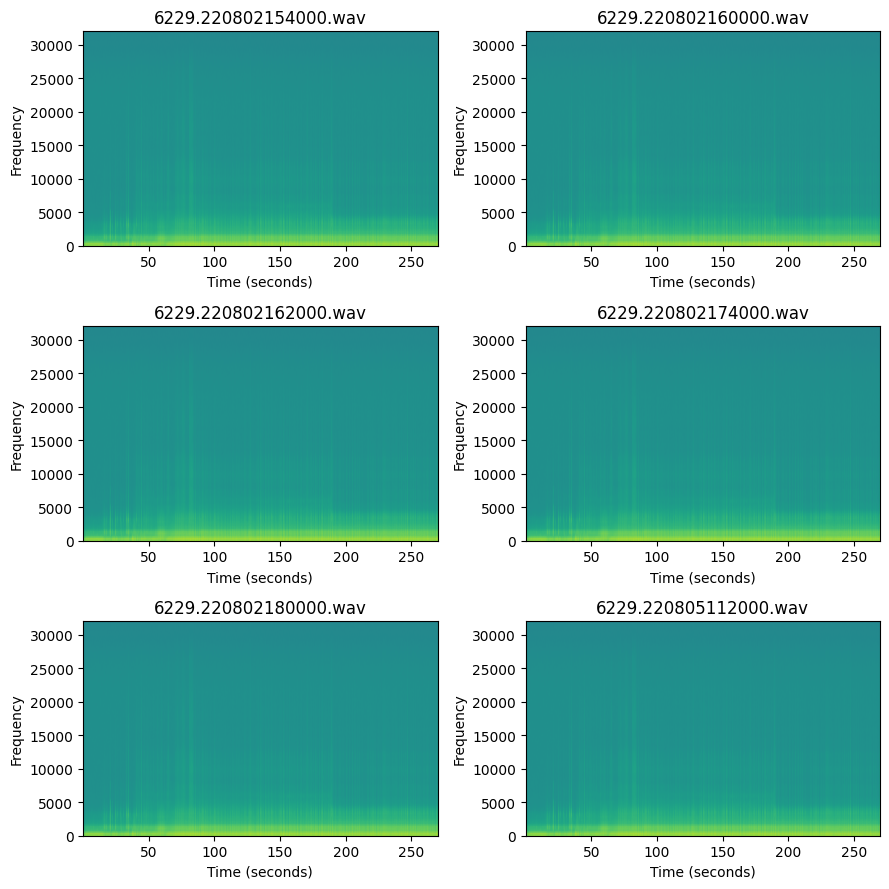

In [45]:
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
axes = axes.flatten()

for i, wav in enumerate(wavelist):
    p = Path(wav)
    wav_file = os.path.join(data_path, sample_name)
    wf, sr = ta.load(wav_file)
    plot_specgram(wf, sr, title=p.name, ax=axes[i])

plt.savefig(fname=graph_path / "spectro_graph.png", bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.tight_layout()
plt.show()